In [1]:
from sunpy.coordinates import get_earth, get_horizons_coord
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import astropy.units as u

INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spacecraft) (-136395) [sunpy.coordinates.ephemeris]


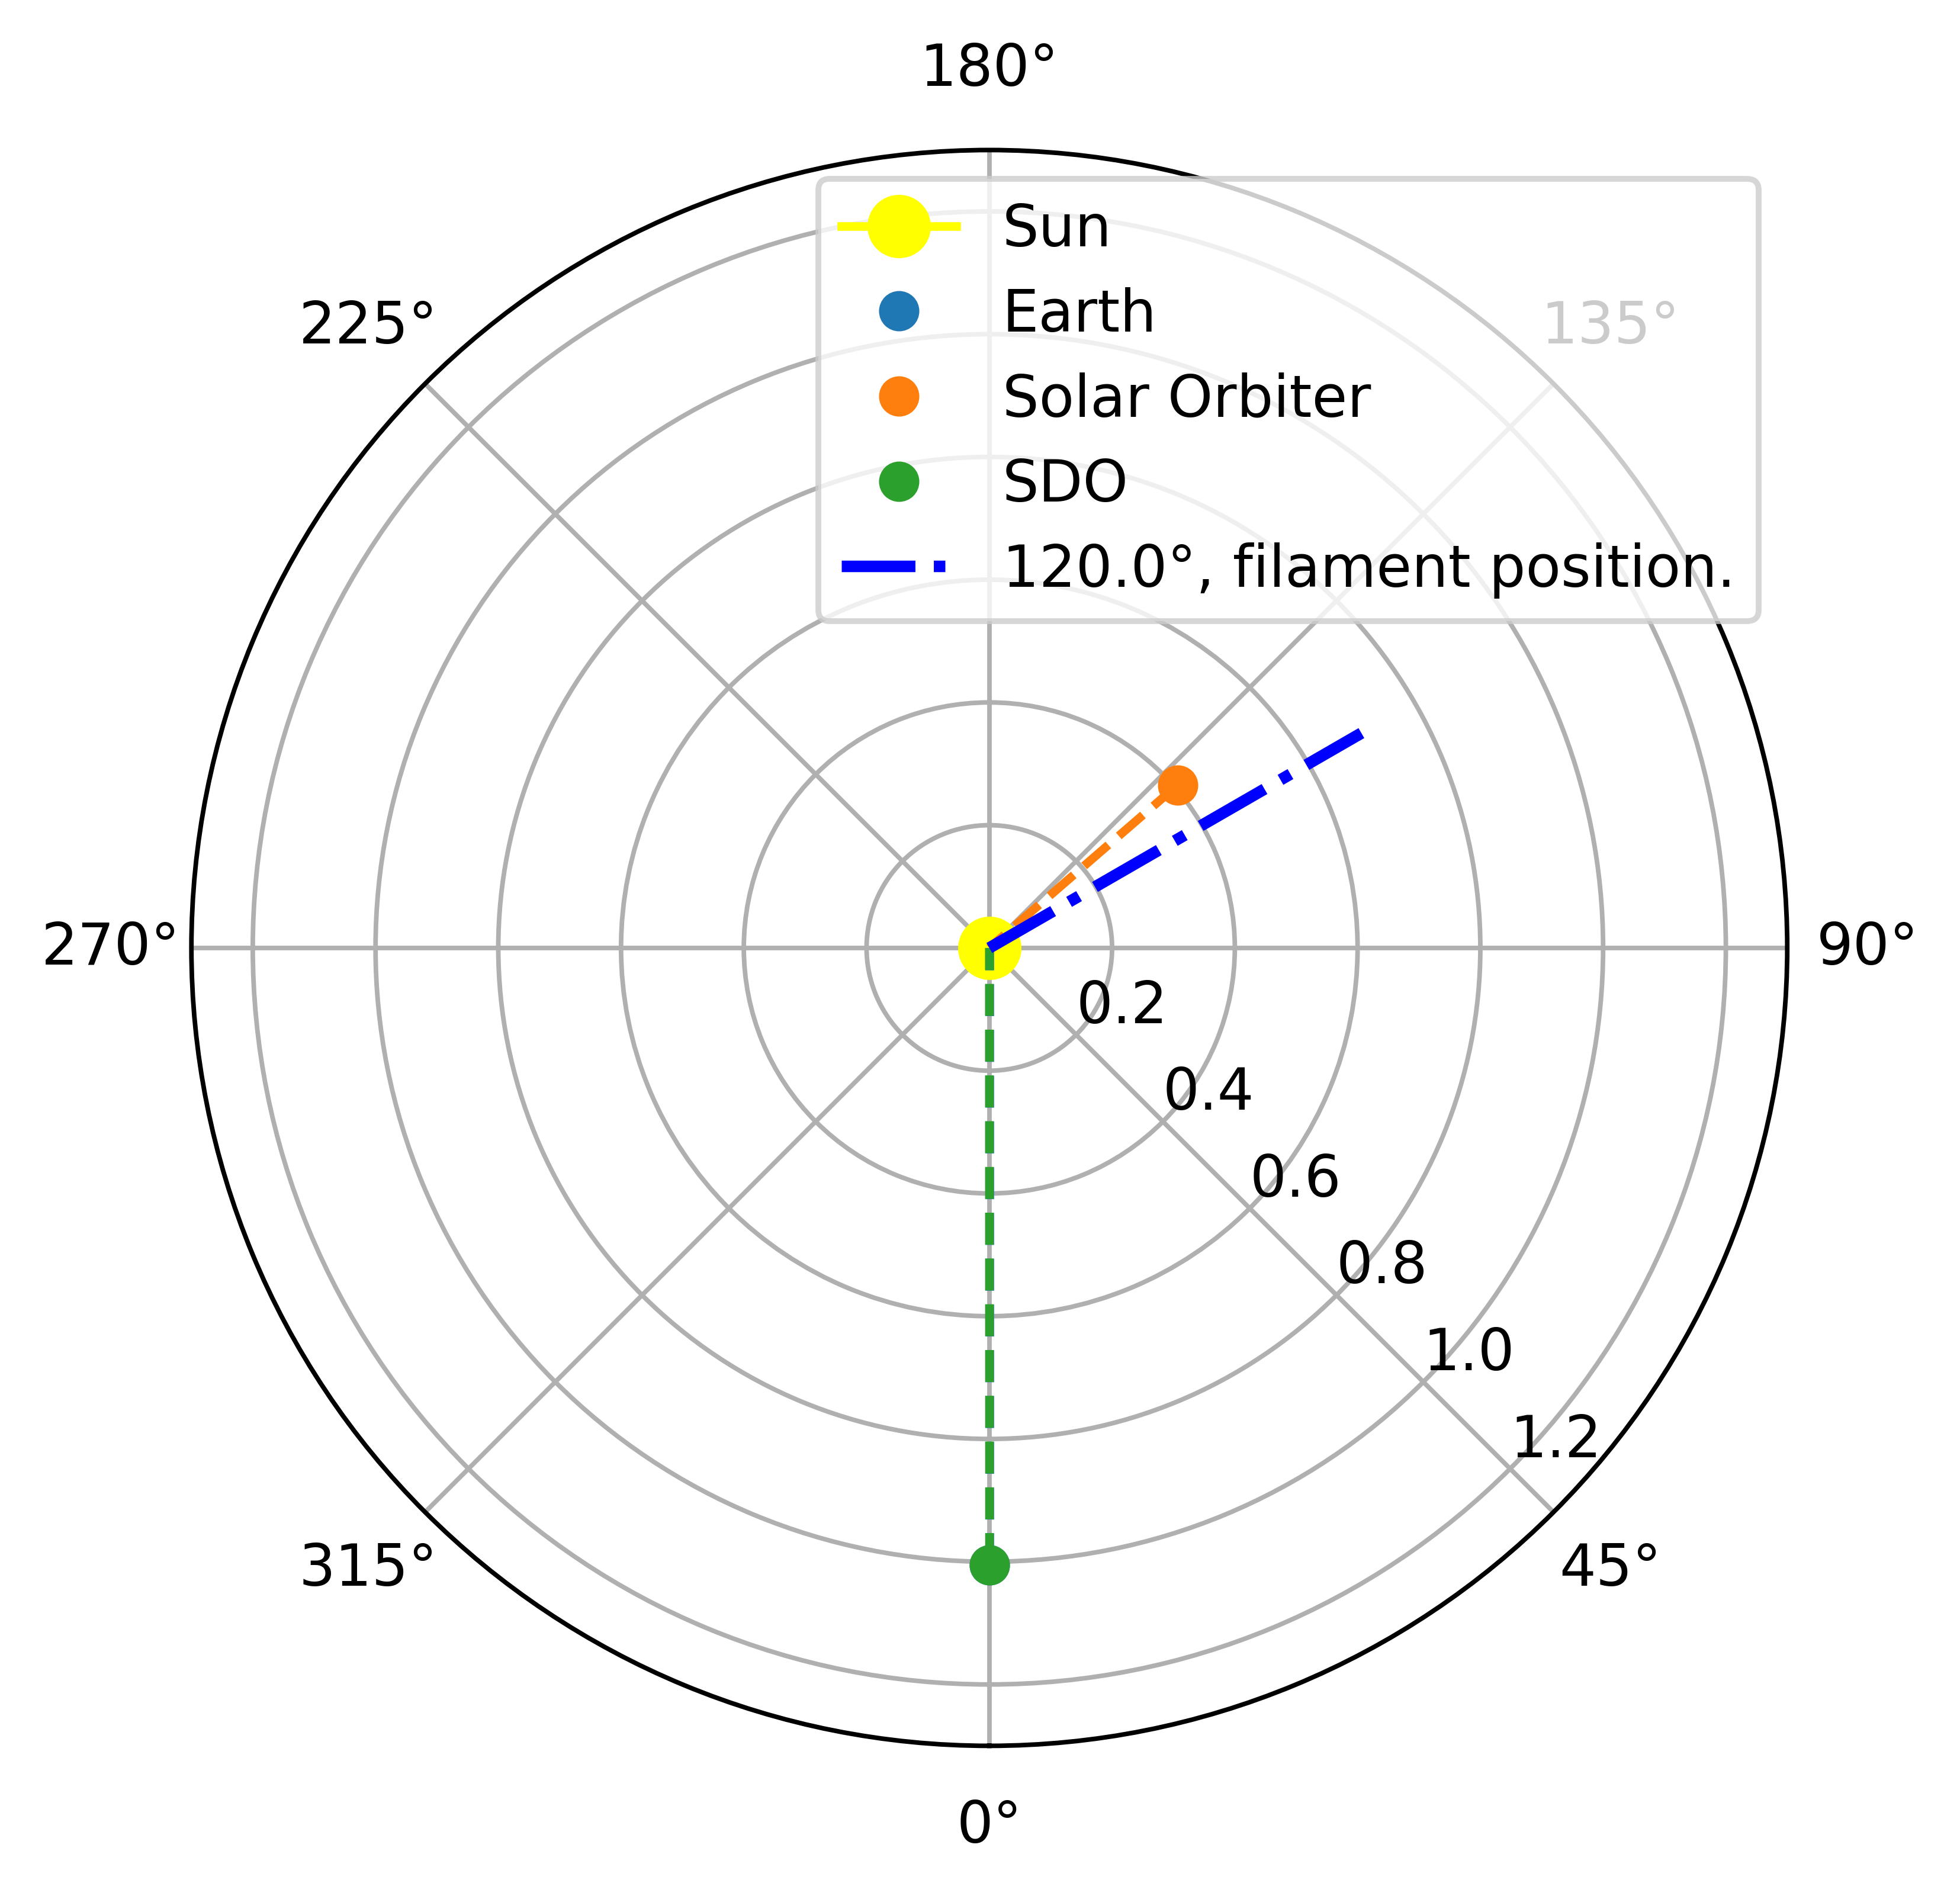

In [2]:
# plot the position of satellite, along with Sun and Earth

def plot_SolO_obs_point_position(obstime, obs_point_lon, obs_point_line_length, satellite_keyword, whether_high_dpi):
    coord_time = obs_time
    get_horizons_coord(satellite_keyword, time=coord_time)

    sun_surface_point_lon = np.deg2rad(obs_point_lon)  # from degree to rad
    sun_surface_point_radius = 1.0  # a imagined point corresponding to the filament position, at distance of 1AU, for convenience of plot
    if whether_high_dpi:
        fig = plt.figure(figsize=(5, 5), dpi=700)
    else:
        fig = plt.figure(figsize=(5, 5))

    ax = plt.subplot(projection='polar')

    # Plot the Sun 并添加到 handles 和 labels 中
    sun_handle = ax.plot(0, 0, marker='o', markersize=10, label='Sun', color='yellow')
    handles = [sun_handle[0]]  # 注意这里使用了 sun_handle[0] 来获取 Line2D 对象
    labels = ['Sun']

    for body_name in ['Earth', 'Solar Orbiter', "SDO"]:
        if body_name == 'Earth':
            body = get_earth(coord_time)
        else:
            body = get_horizons_coord(body_name, time=coord_time)
            
        p, = ax.plot(body.lon.to('rad').value, body.radius.to_value(u.AU), 'o', label=body_name) 
        ax.plot([body.lon.to('rad').value, 0], [body.radius.to_value(u.AU), 0], ls='--', color=p.get_color())
        
        handles.append(p)
        labels.append(body_name)

    # draw a line through the point being analysed, to show its angular position
    line_length = obs_point_line_length 
    line_label = f"{np.rad2deg(sun_surface_point_lon):.1f}°"  
    line, = ax.plot([0, sun_surface_point_lon], [0, line_length * sun_surface_point_radius], 
                    linestyle='-.', color='blue', linewidth=2)
    handles.append(line)
    labels.append(line_label + ", filament position.")

    theta_ticks = np.arange(0, 360, 45)  
    ax.set_xticks(np.deg2rad(theta_ticks))  
    ax.set_xticklabels([f"{int(tick)}°" for tick in theta_ticks])  
    ax.set_theta_zero_location("S")
    ax.set_rlabel_position(45)
    ax.set_rlim(0, 1.3)

    ax.legend(handles, labels)

    plt.show()

obs_time = "2023-04-23 12:05:00"
#obs_time = "2023-10-02 12:00:00"
obs_point_lon = 120    # the obs. point longitude on the solar surface, in degrees unit
satellite_keyword = "solo"
obs_point_line_length = 0.7
whether_high_dpi = True    # if high resolution plt is needed, make this True, and plt dpi would be 700

plot_SolO_obs_point_position(obs_time, obs_point_lon, obs_point_line_length, satellite_keyword, whether_high_dpi)

In [3]:
# distance calculation

import numpy as np
from astropy.io import fits

def read_fits(file_path):
    with fits.open(file_path) as hdul:
        header = hdul[1].header
    return header

def arcsec_to_physical_length(header, start_point, end_point):
    # 获取必要的头信息
    dsun_obs = header.get('DSUN_OBS', None)  # 米
    cdelt1 = header.get('CDELT1', None)  # 角秒
    cdelt2 = header.get('CDELT2', None)  # 角秒
    rsun_ref = header.get('RSUN_REF', 6.955e8)  # 米 (默认太阳半径)

    if dsun_obs is None or cdelt1 is None or cdelt2 is None:
        raise ValueError("缺少必要的FITS头信息")

    # 计算角秒到实际物理长度的转换系数
    scale_factor = dsun_obs * np.pi / (180 * 3600)
    
    # 计算两点之间的像素距离
    pixel_distance = np.sqrt((start_point[0] - end_point[0])**2 + (start_point[1] - end_point[1])**2)

    # 转换像素距离为角秒距离（假设方形像素）
    arcsec_distance = pixel_distance * (cdelt1 + cdelt2) / 2

    # 转换为物理长度（单位：米）
    physical_distance_m = arcsec_distance * scale_factor
    physical_distance_Mm = physical_distance_m / 1e6  # 转换为兆米

    print(f"Satellite Distance from Sun: {dsun_obs / 1e6} Mm")
    print(f"Pixel Distance: {pixel_distance} pixels")
    print(f"Angular Distance: {arcsec_distance} arcsec")
    print(f"Physical Distance: {physical_distance_Mm} Mm")
    
    return physical_distance_Mm

# 示例
file_path = 'D:\\filament_solo_data\\sdo\\aia.lev1_euv_12s.2023-10-02T120007Z.304.image_lev1.fits'
start_point = (700, 1626)
end_point =  (0, 2034)  

header = read_fits(file_path)
arcsec_to_physical_length(header, start_point, end_point)


Satellite Distance from Sun: 149747.6269020484 Mm
Pixel Distance: 810.2246602023416 pixels
Angular Distance: 486.26849048236033 arcsec
Physical Distance: 353.0294567059708 Mm


353.0294567059708

In [4]:


def read_fits(file_path):
    """ 读取 FITS 头文件信息 """
    with fits.open(file_path) as hdul:
        header = hdul[1].header
    return header

def pixel_to_helioprojective(x, y, header):
    """ 将像素坐标转换为 Helioprojective 角秒坐标 """
    xc = header['CRPIX1']  # 参考像素点（日心投影点）
    yc = header['CRPIX2']
    scale = header['CDELT1']  # 角秒/像素

    x_arcsec = (x - xc) * scale
    y_arcsec = (y - yc) * scale
    return x_arcsec, y_arcsec

def arcsec_to_physical_length_corrected(header, start_point, end_point):
    """ 使用正弦定理计算太阳表面修正距离 """
    # 读取 FITS 头文件中的关键信息
    dsun_obs = header.get('DSUN_OBS', None)  # 观测者到太阳中心距离（米）
    rsun_obs = header.get('RSUN_REF', None)  # 太阳半径（米）
    cdelt1 = header.get('CDELT1', None)  # 每像素对应的角秒
    cdelt2 = header.get('CDELT2', None)

    if None in (dsun_obs, rsun_obs, cdelt1, cdelt2):
        raise ValueError("缺少必要的 FITS 头信息")

    # 计算 slice 线中点的角秒坐标
    mid_x = (start_point[0] + end_point[0]) / 2
    mid_y = (start_point[1] + end_point[1]) / 2

    mid_x_arcsec, mid_y_arcsec = pixel_to_helioprojective(mid_x, mid_y, header)

    delta_arcsec = np.sqrt(mid_x_arcsec**2 + mid_y_arcsec**2)
    # print('delta_arcsec ', delta_arcsec )
 
    theta1_rad = np.radians(delta_arcsec / 3600)
    # print('theta1_rad ', theta1_rad)
    # print('sin(theta1_rad) ', np.sin(theta1_rad))

    sin_theta2 = (dsun_obs / rsun_obs) * np.sin(theta1_rad)
    # print('dsun_obs ', dsun_obs, 'rsun_obs ', rsun_obs)
    # print('sin_theta2 ', sin_theta2)
    theta2_rad = (np.pi/2 - np.arcsin(sin_theta2)) + np.pi/2

    theta_corrected_rad = np.radians(180 - np.degrees(theta2_rad) - np.degrees(theta1_rad))
    # print('theta_corrected_rad ', theta_corrected_rad)

    d_eff = dsun_obs - rsun_obs * np.cos(theta_corrected_rad)

    pixel_distance = np.sqrt((start_point[0] - end_point[0])**2 + (start_point[1] - end_point[1])**2)

    arcsec_distance = pixel_distance * (cdelt1 + cdelt2) / 2

    physical_distance_m = arcsec_distance * d_eff * np.pi / (180 * 3600)
    physical_distance_Mm = physical_distance_m / 1e6  # 转换为兆米

    print(f"\n ")
    print(f"Following are the results: \n")
    print(f"卫星到太阳中心距离: {dsun_obs / 1e6} Mm")
    print(f"修正后的卫星到观测slice中点的距离: {d_eff / 1e6} Mm")
    print(f"delta_arcsec: {delta_arcsec} arcsec")
    print(f"theta1: {np.degrees(theta1_rad)} 度")
    print(f"theta2: {np.degrees(theta2_rad)} 度")
    print(f"修正角度 theta_corrected: {np.degrees(theta_corrected_rad)} 度")
    print(f"像素距离: {pixel_distance} pixels")
    print(f"角秒距离: {arcsec_distance} arcsec")
    print(f"物理距离 (修正): {physical_distance_Mm} Mm")

    return physical_distance_Mm



file_path = 'D:\\filament_solo_data\\sdo\\aia.lev1_euv_12s.2023-10-02T120007Z.304.image_lev1.fits'
start_point = (700, 2000)
end_point = (600, 2000)

header = read_fits(file_path)
arcsec_to_physical_length_corrected(header, start_point, end_point)



 
Following are the results: 

卫星到太阳中心距离: 149747.6269020484 Mm
修正后的卫星到观测slice中点的距离: 149424.18569921836 Mm
delta_arcsec: 850.7075272332677 arcsec
theta1: 0.23630764645368546 度
theta2: 117.45543060955974 度
修正角度 theta_corrected: 62.30826174398657 度
像素距离: 100.0 pixels
角秒距离: 60.016500900000004 arcsec
物理距离 (修正): 43.477687438135845 Mm


43.477687438135845